# Reproduce [Toms et al. 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002)

## Data Prep

1. Read in the Cobe Data
2. Select the dates of 1880-2017
3. Calculate climatology for 1980-2009
4. Calculate Anomalies
5. Detrend

## Split data into test and train
1. Train: 1880-1990
2. Test: 1991-2017

## Create a NN with 180x360 input, 2 hidden layers with 8-nodes each

## Apply iNNvestigate using LRP (deep_traylor_ to all input (test and train)

## Make plots to match Figures 6b, 7a, 7b

### Imports

In [1]:
import xarray as xr
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

### Functions

In [2]:
def detrend(da):
    da.values[np.isnan(da.values)] = 0.0
    return signal.detrend(da,axis=0)  

### Read Data, Select times, Reverse lats

In [3]:
fname = '/scratch/kpegion/sst.mon.mean.COBE.nc'
ds = xr.open_dataset(fname,decode_times=True).sel(time=slice('1880-01','2017-12'))
ds=ds.reindex(lat=list(reversed(ds['lat'])))
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1656)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

### Make anomalies

In [4]:
ds_climo = ds.sel(time=slice('1980-01','2009-12')).groupby('time.month').mean(dim='time')
ds_anom = ds.groupby('time.month') - ds_climo

### Detrend and put back into `xr.Dataset`

In [5]:
anoms_detrend = detrend(ds_anom['sst'])

ds_tmp=xr.DataArray(anoms_detrend,
                    coords={'time':ds['time'],
                            'lat':ds['lat'],
                            'lon': ds['lon']},
                    dims=['time','lat','lon'])        
ds_anom_detrend=ds_tmp.to_dataset(name='sst')
ds_anom_detrend

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1656)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    sst      (time, lat, lon) float32 0.0 0.0 0.0 ... 0.02829 0.02819 0.02862

### Make Nino3.4

In [6]:
ds_nino = ds_anom_detrend.sel(lat=slice(-5,5),lon=slice(360-170,360-120)).mean(dim=['lat','lon'])
ds_nino

<xarray.Dataset>
Dimensions:  (time: 1656)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
Data variables:
    sst      (time) float32 -1.808 -0.3871 -0.3249 ... -0.4857 -0.711 -1.056

### Split Train and Test

In [7]:
# Predictors (aka features)
sst_anom_train=ds_anom_detrend.sel(time=slice('1880-01','1990-12'))
sst_anom_test=ds_anom_detrend.sel(time=slice('1991-01','2017-12'))

# Preditcand
nino_train=ds_nino.sel(time=slice('1880-01','1990-12'))
nino_test=ds_nino.sel(time=slice('1991-01','2017-12'))

### Get dimensions for use later

In [8]:
nx=len(ds['lon'])
ny=len(ds['lat'])
nt=len(ds['time'])
nt_train=len(nino_train['sst'])
print(nx,ny,nt,nt_train)

360 180 1656 1332


### Turn into categorization problem with 1's and 0's for warm and cold events

In [9]:
# Predictors ( aka Features ): Training on first nt_train months 
X_train = sst_anom_train['sst'][0:nt_train,:,:].values

# Select El Nino and La Nina (Categorical Predictand)
y_train = nino_train['sst']
l_warm_train = ( y_train > 0.5 )
l_cold_train = ( y_train < -0.5 )
y_train = np.array([l_warm_train,l_cold_train]).T
y_train.shape

(1332, 2)

In [10]:
print("El Nino TRAIN: ",l_warm_train[l_warm_train==True].count().values)
print("La Nina TRAIN: ",l_cold_train[l_cold_train==True].count().values)

El Nino TRAIN:  318
La Nina TRAIN:  350


### Make a keras model

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras import initializers
from keras import optimizers

Using TensorFlow backend.


In [13]:
model = Sequential()
model.add(Dense(8, input_dim=nx*ny,activation='relu',
                kernel_initializer='he_normal',
                kernel_regularizer=l2(25),
                bias_initializer='he_normal'))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(0.01)))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', 
              metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.01,nesterov=True,momentum=0.9)
             )







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train the NN

In [14]:
XX = X_train.reshape(nt_train,nx*ny)
XX[np.isnan(XX)] = 0.0
model.fit(XX, y_train, epochs=100, batch_size=60)

Epoch 1/100
1332/1332 [==============================] - 1s 453us/step - loss: 25.6898 - acc: 0.7016
Epoch 2/100
1332/1332 [==============================] - 0s 237us/step - loss: 0.7383 - acc: 0.7297
Epoch 3/100
1332/1332 [==============================] - 0s 226us/step - loss: 0.8008 - acc: 0.7065
Epoch 4/100
1332/1332 [==============================] - 0s 242us/step - loss: 0.7362 - acc: 0.7297
Epoch 5/100
1332/1332 [==============================] - 0s 295us/step - loss: 0.7935 - acc: 0.7200
Epoch 6/100
1332/1332 [==============================] - 0s 274us/step - loss: 1.0328 - acc: 0.7147
Epoch 7/100
1332/1332 [==============================] - 0s 253us/step - loss: 0.7100 - acc: 0.7327
Epoch 8/100
1332/1332 [==============================] - 0s 333us/step - loss: 0.7439 - acc: 0.7312
Epoch 9/100
1332/1332 [==============================] - 0s 373us/step - loss: 0.7033 - acc: 0.7380
Epoch 10/100
1332/1332 [==============================] - 1s 376us/step - loss: 0.8354 - acc: 0.727

### Apply `iNNvestigate` using all data as input

In [15]:
import innvestigate
import innvestigate.utils

In [16]:
# Predictors ( aka Features ): Training on nt_train months 
X = ds_anom_detrend['sst'].values.reshape(nt,nx*ny)

# Select El Nino and La Nina (Categorical Predictand)
y = ds_nino['sst']
l_warm = ( y > 0.5 )
l_cold = ( y < -0.5 )
y = np.array([l_warm,l_cold]).T
y.shape

(1656, 2)

In [17]:
print("El Nino ALL: ",l_warm[l_warm==True].count().values)

El Nino ALL:  410


In [18]:
# Strip softmax layer
model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("deep_taylor", model)

# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(X)

### Get El Nino Cases, Reshape to `time,lat,lon`

In [19]:
# Get El Nino Cases
a_warm=a[l_warm==True,:]

# Reshape to time,lat,lon
tmp=a_warm.shape
a=a_warm.reshape((tmp[0],ny,nx))

# Find times corresponding to El Nino
ds_time=ds['time'][l_warm==True]

### Make `xarray.Dataset`

In [20]:
ds_tmp=xr.DataArray(a,
                    coords={'time':ds_time,
                            'lat':ds['lat'].values,
                            'lon': ds['lon'].values},
                    dims=['time','lat','lon'])        
ds_lrp=ds_tmp.to_dataset(name='warm')

### Normalize by max value in grid for each input

In [21]:
ds_lrp=ds_lrp/ds_lrp.max(dim=['lat','lon'])
ds_lrp

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 410)
Coordinates:
  * time     (time) datetime64[ns] 1880-12-01 1881-01-01 ... 2016-05-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    warm     (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0 -0.0

### Plot Composite Relevance: Should match Figure 6b of Toms et al. 2020

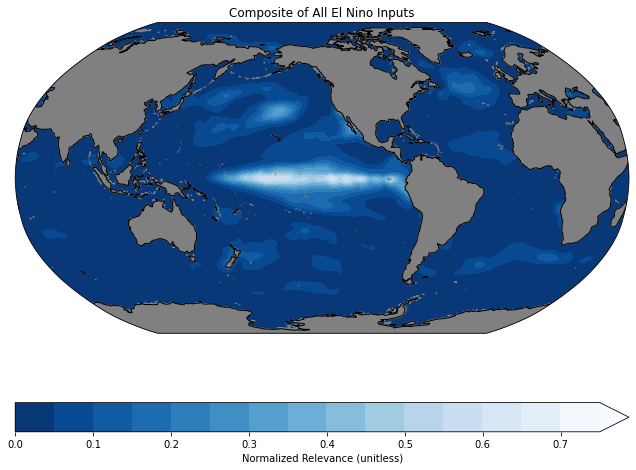

In [22]:
from cartopy.util import add_cyclic_point
clevs=np.arange(0.0,0.8,.05)

fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=230))
data, lons = add_cyclic_point(ds_lrp['warm'].mean(dim='time'), coord=ds['lon'])
cs=ax.contourf(lons, ds['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='max')
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m', 
                                            edgecolor='gray', facecolor='gray'))
ax.coastlines()
ax.set_title('Composite of All El Nino Inputs')
plt.colorbar(cs,orientation='horizontal',label='Normalized Relevance (unitless)')

### Plot May 1998: Should match Figure 7a of Toms et al. 2020

In [23]:
ds_may1998=ds_lrp['warm'].sel(time='1998-05').squeeze()
ds_may1998

<xarray.DataArray 'warm' (lat: 180, lon: 360)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1998-05-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

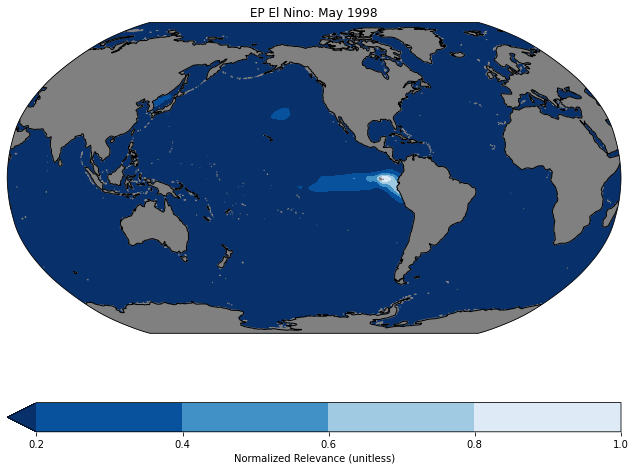

In [24]:
clevs=np.arange(0.2,1.2,0.2)

fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=230))
data, lons = add_cyclic_point(ds_may1998, coord=ds['lon'])
cs=ax.contourf(lons, ds['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='min')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='gray', facecolor='gray'))
ax.coastlines()
ax.set_title('EP El Nino: May 1998')
plt.colorbar(cs,orientation='horizontal',label='Normalized Relevance (unitless)')

### Plot Feb 1987: Should match Figure 7b of Toms et al. 2020

In [25]:
ds_feb1987=ds_lrp['warm'].sel(time='1987-02').squeeze()
ds_feb1987

<xarray.DataArray 'warm' (lat: 180, lon: 360)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1987-02-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

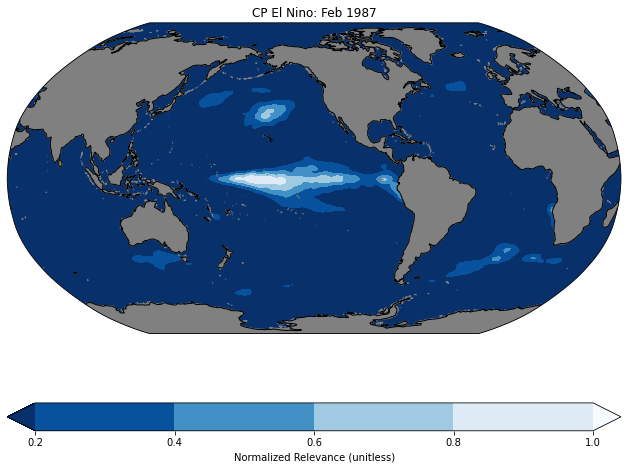

In [26]:
fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=230))
data, lons = add_cyclic_point(ds_feb1987, coord=ds['lon'])
cs=ax.contourf(lons, ds['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='both')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='gray', facecolor='gray'))
ax.coastlines()
ax.set_title('CP El Nino: Feb 1987')
plt.colorbar(cs,orientation='horizontal',label='Normalized Relevance (unitless)')